In [270]:
import numpy as np
import pandas as pd
import ROOT
import subprocess
import glob
import os
import argparse
from io import StringIO
import re

os.chdir("../input")

In [2]:
def sort_lists(to_sort, sort_idx):
    return [l[sort_idx] for l in to_sort]

In [3]:
def fill_bar(h, x, w, d, c, s):
    h.Fill(x, w)
    h.SetBinError(h.FindBin(x), d)
    h.SetLineColor(c)
    h.SetFillColor(c)
    if s:
        h.SetFillStyle(s)

# With unpacking

## With repetition per bar

In [55]:
def run_packed_benchmark_gpu(files, n, m, w):
    n_pts = len(files)
    setup_times = np.zeros(n_pts)
    dev_st = np.zeros(n_pts)
    decomp_times = np.zeros(n_pts)
    dev_dt = np.zeros(n_pts)
    unpack_times = np.zeros(n_pts)
    dev_pt = np.zeros(n_pts)
    ratios = np.zeros(n_pts)
    sizes = np.zeros(n_pts)

    for i, f in enumerate(files):
        result = subprocess.run(
            [
                "../gpu_root_decomp",
                "-f",
                f,
                "-t",
                f.split(".")[-1],
                "-n",
                str(n),
                "-m",
                str(m),
                "-w",
                str(w),
                "-p"
            ],
            stdout=subprocess.PIPE,
        )

        output = result.stdout.decode("utf-8").split()
        ratios[i], setup_times[i], dev_st[i], decomp_times[i], dev_dt[i], unpack_times[i], dev_pt[i] = [
            float(o) for o in output[-7:]
        ]
        sizes[i] = int(f.split(".")[1]) 

#     print(setup_times, dev_st, decomp_times, dev_dt, ratios, sizes)
    return setup_times, dev_st, decomp_times, dev_dt, unpack_times, dev_pt, ratios, sizes

def run_packed_benchmark_cpu(files, n, m, w, c=16):
    n_pts = len(files)
    decomp_times = np.zeros(n_pts)
    dev_dt = np.zeros(n_pts)
    unpack_times = np.zeros(n_pts)
    dev_pt = np.zeros(n_pts)
    ratios = np.zeros(n_pts)
    sizes = np.zeros(n_pts)

    for i, f in enumerate(files):
        result = subprocess.run(
            [
                "../cpu_root_decomp",
                "-f",
                f,
                "-s",
                f.split(".")[1],
                "-n",
                str(n),
                "-m",
                str(m),
                "-c",
                str(c),
                "-w",
                str(w),
                "-p"
            ],
            stdout=subprocess.PIPE,
        )
        output = result.stdout.decode("utf-8").split()
        ratios[i] = float(output[-21])
        decomp_times[i] = float(output[-15])
        dev_dt[i] = float(output[-11])
        unpack_times[i] = float(output[-5])
        dev_pt[i] = float(output[-1])
        sizes[i] = int(f.split(".")[1]) 

#     print(decomp_times, dev_dt, sizes)
    return decomp_times, dev_dt, unpack_times, dev_pt, ratios, sizes

## With repetition over the whole graph instead of per bar

In [236]:
def run_packed_benchmark_gpu(files, n, m, w):
    n_pts = len(files)

    # averaged
    setup_times = np.zeros(n_pts)
    dev_st = np.zeros(n_pts)
    decomp_times = np.zeros(n_pts)
    dev_dt = np.zeros(n_pts)
    unpack_times = np.zeros(n_pts)
    dev_pt = np.zeros(n_pts)
    ratios = np.zeros(n_pts)
    sizes = np.zeros(n_pts)

    for i, f in enumerate(files):
        tmp = []
        for j in range(n):
            result = subprocess.run(
                [
                    "../gpu_root_decomp",
                    "-f", f,
                    "-t", f.split(".")[-1],
                    "-n", "1",
                    "-m", str(m),
                    "-w", str(w),
                    "-p"
                ],
                stdout=subprocess.PIPE,
            )
        
            output = result.stdout.decode("utf-8").split()
            tmp.append([float(output[-7]), float(output[-6]), float(output[-4]), float(output[-2]), int(f.split(".")[1])])

        ratios[i], setup_times[i], decomp_times[i], unpack_times[i], sizes[i] = np.mean(tmp, axis=0)
        dev_st[i], dev_dt[i], dev_pt[i] = np.std(tmp, axis=0)[1:-1]

    return setup_times, dev_st, decomp_times, dev_dt, unpack_times, dev_pt, ratios, sizes

def run_packed_benchmark_cpu(files, n, m, w, c=16):
    n_pts = len(files)
    decomp_times = np.zeros(n_pts)
    dev_dt = np.zeros(n_pts)
    unpack_times = np.zeros(n_pts)
    dev_pt = np.zeros(n_pts)
    ratios = np.zeros(n_pts)
    sizes = np.zeros(n_pts)

    for i, f in enumerate(files):
        tmp = []
        for j in range(n):
            result = subprocess.run(
                [
                    "../cpu_root_decomp",
                    "-f", f,
                    "-s", f.split(".")[1],
                    "-n", "1",
                    "-m", str(m),
                    "-c", str(c),
                    "-w", str(w),
                    "-p"
                ],
                stdout=subprocess.PIPE,
            )

            output = result.stdout.decode("utf-8").split()
            tmp.append([float(output[-21]), float(output[-15]), float(output[-5]), int(f.split(".")[1])])

        ratios[i], decomp_times[i], unpack_times[i], sizes[i] = np.mean(tmp, axis=0)
        dev_dt[i], dev_pt[i] = np.std(tmp, axis=0)[1:-1]

    return decomp_times, dev_dt, unpack_times, dev_pt, ratios, sizes

## Plotting

### CPU + GPU

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1
Warning in <TROOT::Append>: Replacing existing TH1: c_decomp1 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: c_unpack1 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: g_setup1 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: g_decomp1 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: g_unpack1 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: c_decomp2 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: c_unpack2 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: g_setup2 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: g_decomp2 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: g_unpack2 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: c_decomp4 

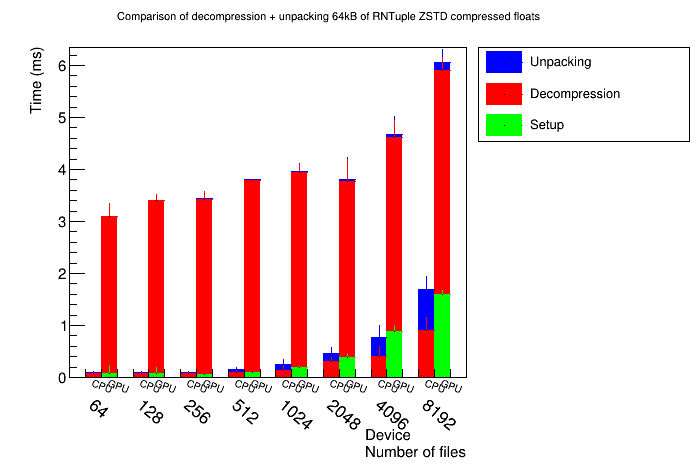

In [241]:
n = 10
warmup = 3
nfiles = [1, 2, 4, 8, 16, 32, 64, 128]
file = glob.glob("packed_floats.64000.root.zstd")
nbins = 2 * len(nfiles) + len(nfiles) + 1

title = f"Comparison of decompression + unpacking {int(int(file[0].split('.')[1])/1000)}kB of RNTuple ZSTD compressed floats"
c = ROOT.TCanvas("c1", title)
hs = ROOT.THStack("hs", "")

for i, m in enumerate(nfiles):
    (
        g_setup_times,
        g_dev_st,
        g_decomp_times,
        g_dev_dt,
        g_unpack_times,
        g_dev_pt,
        g_ratios,
        g_sizes,
    ) = run_packed_benchmark_gpu(file, n, m, warmup)
    (
        c_decomp_times,
        c_dev_dt,
        c_unpack_times,
        c_dev_pt,
        c_ratios,
        c_sizes,
    ) = run_packed_benchmark_cpu(file, n, m, warmup, 16)

    # CPU

    cpu_bin = 1 + 3*i
    h1 = ROOT.TH1F(f"c_decomp{m}", "cpu", nbins, 0, nbins)
    fill_bar(h1, cpu_bin, c_decomp_times, c_dev_dt, ROOT.kRed, None)
    hs.Add(h1)

    h2 = ROOT.TH1F(f"c_unpack{m}", "cpu", nbins, 0, nbins)
    fill_bar(h2, cpu_bin, c_unpack_times, c_dev_pt, ROOT.kBlue, None)
    hs.Add(h2)

    # GPU

    gpuFillStyle = 1001
    gpu_bin = 2 + 3*i
    h3 = ROOT.TH1F(f"g_setup{m}", "gpu", nbins, 0, nbins)
    fill_bar(h3, gpu_bin, g_setup_times, g_dev_st, ROOT.kGreen, gpuFillStyle)
    hs.Add(h3)

    h4 = ROOT.TH1F(f"g_decomp{m}", "gpu", nbins, 0, nbins)
    fill_bar(h4, gpu_bin, g_decomp_times, g_dev_dt, ROOT.kRed, gpuFillStyle)
    hs.Add(h4)

    h5 = ROOT.TH1F(f"g_unpack{m}", "gpu", nbins, 0, nbins)
    fill_bar(h5, gpu_bin, g_unpack_times, g_dev_pt, ROOT.kBlue, gpuFillStyle)
    hs.Add(h5)

c.SetRightMargin(0.33)
c.SetBottomMargin(0.2)
l = ROOT.TLegend(0.687, 0.7, 0.99, 0.9)
l.AddEntry(h5, "Unpacking")
l.AddEntry(h4, "Decompression")
l.AddEntry(h3, "Setup")
l.SetTextSize(0.03)

hs.Draw("bar")
h1.SetContour(30)

xaxis = hs.GetXaxis()
xaxis.SetTitle("#splitline{Device}{Number of files}")
xaxis.SetTitleOffset(2.5)
for i in range(2, nbins, 3):
    xaxis.SetBinLabel(i, "CPU")
    xaxis.SetBinLabel(i + 1, "GPU")

xaxis.SetTickLength(0)
hs.SetTitle(title)

ox = ROOT.TGaxis(
    0, 0,       # xmin, ymin 
    nbins, 0,   # xmax, ymax
    0, nbins, # wmin, wmax
    nbins, "M"   # ndiv, chopt
)
ox.SetTickSize(0)
ox.SetLabelOffset(0.02)
ox.SetLabelFont(42)

labelbins = range(2, nbins, 3)

for i in range(nbins + 1):
    if i not in labelbins:
        ox.ChangeLabel(i, -1, 0.0)
for i, e in enumerate(labelbins):
    ox.ChangeLabel(e, 320, -1, 12, -1, -1, f"{nfiles[i] * 64}")

ox.Draw()

yaxis = hs.GetYaxis()
yaxis.SetTitle("Time (ms)")

l.Draw()
c.Draw()

### CPU Only

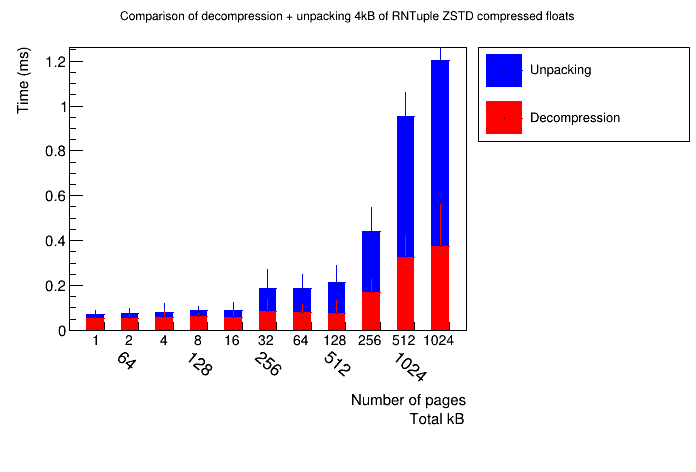

In [5]:
n = 10
warmup = 5
nfiles = [1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]
file = glob.glob("packed_floats.4000.root.zstd")
nbins = len(nfiles) + len(nfiles) + 1

title = f"Comparison of decompression + unpacking {int(int(file[0].split('.')[1])/1000)}kB of RNTuple ZSTD compressed floats"
c = ROOT.TCanvas("c1", title)
hs = ROOT.THStack("hs", "")

for i, m in enumerate(nfiles):
    (
        c_decomp_times,
        c_dev_dt,
        c_unpack_times,
        c_dev_pt,
        c_ratios,
        c_sizes,
    ) = run_packed_benchmark_cpu(file, n, m, warmup, 16)

    # CPU

    cpu_bin = 1 + 2*i
    h1 = ROOT.TH1F(f"c_decomp{m}", "cpu", nbins, 0, nbins)
    fill_bar(h1, cpu_bin, c_decomp_times, c_dev_dt, ROOT.kRed, None)
    hs.Add(h1)

    h2 = ROOT.TH1F(f"c_unpack{m}", "cpu", nbins, 0, nbins)
    fill_bar(h2, cpu_bin, c_unpack_times, c_dev_pt, ROOT.kBlue, None)
    hs.Add(h2)

c.SetRightMargin(0.33)
c.SetBottomMargin(0.3)
l = ROOT.TLegend(0.687, 0.7, 0.99, 0.9)
l.AddEntry(h2, "Unpacking")
l.AddEntry(h1, "Decompression")
l.SetTextSize(0.03)

hs.Draw("bar")
hs.SetTitle(title)

xaxis = hs.GetXaxis()
xaxis.SetTitle("#splitline{Number of pages}{              Total kB}")
xaxis.SetTitleOffset(3)
xaxis.SetLabelSize(0.05)
for i, e in enumerate(range(2, nbins, 2)):
    xaxis.SetBinLabel(e, f"{nfiles[i]}")
xaxis.LabelsOption("hM")
xaxis.SetTickSize(0)

yaxis = hs.GetYaxis()
yaxis.SetTitle("Time (ms)")

ox = ROOT.TGaxis(
    0, 0,       # xmin, ymin 
    nbins, 0,   # xmax, ymax
    0, nbins, # wmin, wmax
    20, "M"   # ndiv, chopt
)
ox.SetTickSize(0)
ox.SetLabelOffset(0.02)
ox.SetLabelFont(42)

labelbins = range(2, nbins, 2)
for i in range(20):
    if i not in labelbins:
        ox.ChangeLabel(i, -1, 0.0)
for i, e in enumerate(labelbins):
    ox.ChangeLabel(e, 320, -1, 12, -1, -1, f"{nfiles[i] * 64}")
    # TGaxis::ChangeLabel(int labNum = 0, double labAngle = -1., double labSize = -1., int labAlign = -1, int labColor = -1, int labFont = -1, TString labText = "") 

ox.Draw()
l.Draw()
c.Draw()

### GPU Only

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1
Warning in <TROOT::Append>: Replacing existing TH1: g_setup1 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: g_decomp1 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: g_unpack1 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: g_setup2 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: g_decomp2 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: g_unpack2 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: g_setup4 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: g_decomp4 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: g_unpack4 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: g_setup8 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: g_decomp8 (P

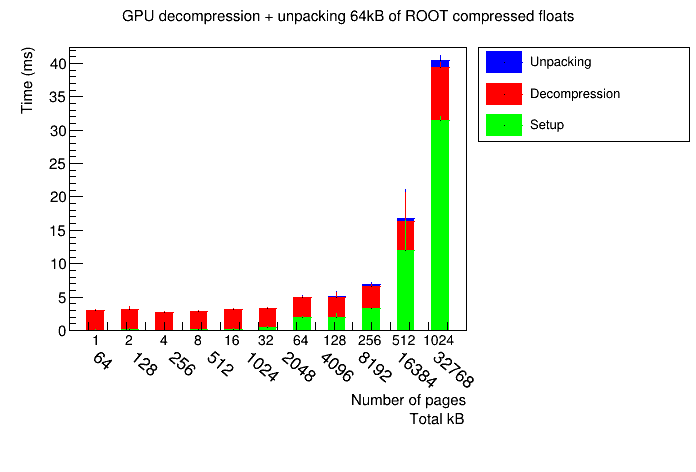

In [35]:
n = 10
w = 5
nfiles = [1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]
file = glob.glob("packed_floats.64000.root.zstd")
nbins = len(nfiles) + len(nfiles) + 1

title = f"GPU decompression + unpacking 64kB of ROOT compressed floats"
c = ROOT.TCanvas("c1", title)
hs = ROOT.THStack("hs", "")

for i, m in enumerate(nfiles):
    (
        g_setup_times,
        g_dev_st,
        g_decomp_times,
        g_dev_dt,
        g_unpack_times,
        g_dev_pt,
        g_ratios,
        g_sizes,
    ) = run_packed_benchmark_gpu(file, n, m, w)
    
    # GPU

    gpuFillStyle = 1001
    gpu_bin = 1 + 2*i
    h3 = ROOT.TH1F(f"g_setup{m}", "gpu", nbins, 0, nbins)
    fill_bar(h3, gpu_bin, g_setup_times, g_dev_st, ROOT.kGreen, gpuFillStyle)
    hs.Add(h3)

    h4 = ROOT.TH1F(f"g_decomp{m}", "gpu", nbins, 0, nbins)
    fill_bar(h4, gpu_bin, g_decomp_times, g_dev_dt, ROOT.kRed, gpuFillStyle)
    hs.Add(h4)

    h5 = ROOT.TH1F(f"g_unpack{m}", "gpu", nbins, 0, nbins)
    fill_bar(h5, gpu_bin, g_unpack_times, g_dev_pt, ROOT.kBlue, gpuFillStyle)
    hs.Add(h5)

c.SetRightMargin(0.33)
c.SetBottomMargin(0.3)
l = ROOT.TLegend(0.687, 0.7, 0.99, 0.9)
l.AddEntry(h5, "Unpacking")
l.AddEntry(h4, "Decompression")
l.AddEntry(h3, "Setup")
l.SetTextSize(0.03)

hs.Draw("bar")
hs.SetTitle(title)

xaxis = hs.GetXaxis()
xaxis.SetTitle("#splitline{Number of pages}{              Total kB}")
xaxis.SetTitleOffset(3)
xaxis.SetLabelSize(0.05)
for i, e in enumerate(range(2, nbins, 2)):
    xaxis.SetBinLabel(e, f"{nfiles[i]}")
xaxis.LabelsOption("hM")
xaxis.SetTickSize(0)

yaxis = hs.GetYaxis()
yaxis.SetTitle("Time (ms)")

ox = ROOT.TGaxis(
    0, 0,       # xmin, ymin 
    nbins, 0,   # xmax, ymax
    0, 21, # wmin, wmax
    21, "M"   # ndiv, chopt
)
ox.SetTickSize(0)
ox.SetLabelOffset(0.02)
ox.SetLabelFont(42)

labelbins = range(2, nbins, 2)
for i in range(30):
    if i not in labelbins:
        ox.ChangeLabel(i, -1, 0.0)
for i, e in enumerate(labelbins):
    ox.ChangeLabel(e, 320, -1, 12, -1, -1, f"{nfiles[i] * 64}")
    # TGaxis::ChangeLabel(int labNum = 0, double labAngle = -1., double labSize = -1., int labAlign = -1, int labColor = -1, int labFont = -1, TString labText = "") 

ox.Draw()
l.Draw()
c.Draw()

# Nsys results

In [295]:
def get_dataframe(s, index):
    return pd.read_csv(StringIO("\n".join(s))).sort_values(["Total Time (ns)"]).groupby([index])

def run_nsys_stat(files, n, m, w):
    nfiles = len(files)
    api_s = [[] for _ in range(nfiles)]
    kernel_s = [[] for _ in range(nfiles)]
    memops_s = [[] for _ in range(nfiles)]

    for iter in range(n):
        for i, f in enumerate(files):
            # Profile code with nsys
            subprocess.run(
                [
                    "nsys", "profile",
                    "-otemp",
                    "../gpu_root_decomp",
                    "-f", f,
                    "-t", f.split(".")[-1],
                    "-n", "1",
                    "-m", str(m),
                    "-w", str(w),
                    "-p"
                ],
                stdout=subprocess.PIPE,
            )

            # Gather statistics
            result = subprocess.run(
                [
                    "nsys", "stats",
                    "temp.nsys-rep",
                    "--format=csv"
                ],
                stdout=subprocess.PIPE,
            )
            subprocess.run(["rm", "temp.nsys-rep"])
            output = result.stdout.decode("utf-8").split("\n\n")

            # Skip header after first iteration
            api_s[i] += output[2].split("\n")[(1 + (iter != 0 )):]
            kernel_s[i] += output[3].split("\n")[(1 + (iter != 0)):]
            memops_s[i] += output[4].split("\n")[(1 + (iter != 0)):]

    # Create a dictionary with file names as keys and a dataframe containing the statistics for each kernel/api call.
    api_calls = {f : get_dataframe(s, "Name") for s, f in zip(api_s, files)}
    kernel_calls = {f : pd.read_csv(StringIO("\n".join(s))).groupby(["Name"]) for s, f in zip(kernel_s, files)}
    memops = {f : pd.read_csv(StringIO("\n".join(s))).groupby(["Operation"]) for s, f in zip(memops_s, files)}
    return api_calls, kernel_calls, memops

In [297]:
def filter_name(n):
    n = re.sub("[<\(\[].*?[>\)\]]", "", n)
    for w in ["unsigned", "int", "char", "float", "void", "const", "long", "*"]:
        n = n.replace(w, "")
    return n.strip()
    
n = 1
w = 0
files = glob.glob("packed_floats.*.root.zstd")
api_calls, kernel_calls, memops = run_nsys_stat(files, n, m, w)

nbins = len(nfiles) + len(nfiles) + 1
title = f"GPU decompression + unpacking 64kB of ROOT compressed floats"
c = ROOT.TCanvas("c1", title)
hs = ROOT.THStack("hs", "")

for i, f in enumerate(files):  
    kernels = kernel_calls[f]
    # kernel_names = 
    # print(kernels)
    
    # # GPU
    # gpuFillStyle = 1001
    # gpu_bin = 1 + 2*i
    # h3 = ROOT.TH1F(f"g_setup{m}", "gpu", nbins, 0, nbins)
    # fill_bar(h3, gpu_bin, g_setup_times, g_dev_st, ROOT.kGreen, gpuFillStyle)
    # hs.Add(h3)

    # h4 = ROOT.TH1F(f"g_decomp{m}", "gpu", nbins, 0, nbins)
    # fill_bar(h4, gpu_bin, g_decomp_times, g_dev_dt, ROOT.kRed, gpuFillStyle)
    # hs.Add(h4)

    # h5 = ROOT.TH1F(f"g_unpack{m}", "gpu", nbins, 0, nbins)
    # fill_bar(h5, gpu_bin, g_unpack_times, g_dev_pt, ROOT.kBlue, gpuFillStyle)
    # hs.Add(h5)

# c.SetRightMargin(0.33)
# c.SetBottomMargin(0.3)
# l = ROOT.TLegend(0.687, 0.7, 0.99, 0.9)
# l.AddEntry(h5, "Unpacking")
# l.AddEntry(h4, "Decompression")
# l.AddEntry(h3, "Setup")
# l.SetTextSize(0.03)

# hs.Draw("bar")
# hs.SetTitle(title)

# xaxis = hs.GetXaxis()
# xaxis.SetTitle("#splitline{Number of pages}{              Total kB}")
# xaxis.SetTitleOffset(3)
# xaxis.SetLabelSize(0.05)
# for i, e in enumerate(range(2, nbins, 2)):
#     xaxis.SetBinLabel(e, f"{nfiles[i]}")
# xaxis.LabelsOption("hM")
# xaxis.SetTickSize(0)

# yaxis = hs.GetYaxis()
# yaxis.SetTitle("Time (ms)")

# ox = ROOT.TGaxis(
#     0, 0,       # xmin, ymin 
#     nbins, 0,   # xmax, ymax
#     0, 21, # wmin, wmax
#     21, "M"   # ndiv, chopt
# )
# ox.SetTickSize(0)
# ox.SetLabelOffset(0.02)
# ox.SetLabelFont(42)

# labelbins = range(2, nbins, 2)
# for i in range(30):
#     if i not in labelbins:
#         ox.ChangeLabel(i, -1, 0.0)
# for i, e in enumerate(labelbins):
#     ox.ChangeLabel(e, 320, -1, 12, -1, -1, f"{nfiles[i] * 64}")
#     # TGaxis::ChangeLabel(int labNum = 0, double labAngle = -1., double labSize = -1., int labAlign = -1, int labColor = -1, int labFont = -1, TString labText = "") 

# ox.Draw()
# l.Draw()
# c.Draw()

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1


In [293]:
kernels.sortby(["Total Time (ns)"])

AttributeError: 'DataFrameGroupBy' object has no attribute 'sortby'

In [268]:
kernels.mean()

,Time (%),Total Time (ns),Instances,Avg (ns),Med (ns),Min (ns),Max (ns),StdDev (ns)
Name,,,,,,,,
"void Unpack4_1<float, float>(void *, const void *, const unsigned long *, unsigned long, unsigned long)",9.5,1200714.0,1.0,1200714.0,1200714.0,1200714.0,1200714.0,0.0
"void zstd::classify_frames<(int)2>(const unsigned char *const *, zstd::DeviceBlockShare *, unsigned long, unsigned long *, unsigned long, int *, int *, int *, zstd::ZstdFrame *, unsigned char *const *, const unsigned long *)",0.1,10528.0,1.0,10528.0,10528.0,10528.0,10528.0,0.0
"zstd::decompression_kernel(const unsigned char *const *, unsigned char *const *, unsigned long *, const unsigned long *, unsigned long, unsigned char *, unsigned long *, unsigned long, zstd::ZstdFrame *, zstd::DeviceBlockShare *, int *, int *, int *, int *, const int *, const int *, const int *)",81.3,10268308.0,1.0,10268308.0,10268308.0,10268308.0,10268308.0,0.0
"zstd::init_buffer_vals(unsigned long, unsigned char *, unsigned long, int *)",0.0,2400.0,1.0,2400.0,2400.0,2400.0,2400.0,0.0
"zstd::init_fse_tables(unsigned char *, unsigned long *, unsigned long, int *, const int *, zstd::DeviceBlockShare *)",9.0,1136297.0,1.0,1136297.0,1136297.0,1136297.0,1136297.0,0.0
"zstd::init_huff_tables(unsigned char *, unsigned long *, unsigned long, int *, const int *, zstd::DeviceBlockShare *)",0.0,5856.0,1.0,5856.0,5856.0,5856.0,5856.0,0.0


# Collect Unpacked Results

In [9]:
def run_benchmark_gpu(files, n, m, w):
    n_pts = len(files)
    setup_times = np.zeros(n_pts)
    dev_st = np.zeros(n_pts)
    decomp_times = np.zeros(n_pts)
    dev_dt = np.zeros(n_pts)
    ratios = np.zeros(n_pts)
    sizes = np.zeros(n_pts)

    for i, f in enumerate(files):
        result = subprocess.run(
            [
                "../gpu_root_decomp",
                "-f",
                f,
                "-t",
                f.split(".")[-1],
                "-n",
                str(n),
                "-m",
                str(m),
                "-w",
                str(w),
            ],
            stdout=subprocess.PIPE,
        )

        output = result.stdout.decode("utf-8").split()
        ratios[i], setup_times[i], dev_st[i], decomp_times[i], dev_dt[i] = [
            float(o) for o in output[-7:-2]
        ]
        sizes[i] = int(f.split(".")[1]) 

#     print(setup_times, dev_st, decomp_times, dev_dt, ratios, sizes)
    return setup_times, dev_st, decomp_times, dev_dt, ratios, sizes

In [10]:
def run_benchmark_cpu(files, n, m, w, c=16, debug=False):
    n_pts = len(files)
    decomp_times = np.zeros(n_pts)
    dev_dt = np.zeros(n_pts)
    ratios = np.zeros(n_pts)
    sizes = np.zeros(n_pts)

    for i, f in enumerate(files):
        result = subprocess.run(
            [
                "../cpu_root_decomp",
                "-f",
                f,
                "-s",
                f.split(".")[1],
                "-n",
                str(n),
                "-m",
                str(m),
                "-c",
                str(c),
                "-w",
                str(w),
            
            ],
            stdout=subprocess.PIPE,
        )
        output = result.stdout.decode("utf-8").split()
        if debug:
            print(result.stdout.decode("utf-8"))
        ratios[i] = float(output[-11])
        decomp_times[i] = float(output[-5])
        dev_dt[i] = float(output[-1])
        sizes[i] = int(f.split(".")[1]) 

#     print(decomp_times, dev_dt, sizes)
    return decomp_times, dev_dt, ratios, sizes

# Same batch size, different chunk size

In [11]:
def plot_against_size(c, cpu_results, gpu_results, title):
    cpu_decomp_times, cpu_dev_dt, _, _ = cpu_results
    (
        gpu_setup_times,
        gpu_dev_st,
        gpu_decomp_times,
        gpu_dev_dt,
        ratios,
        sizes,
    ) = gpu_results

    n_pts = len(sizes)
    zeroes = np.zeros(n_pts, dtype=float)

    mg = ROOT.TMultiGraph()
    g1 = ROOT.TGraphErrors(n_pts, sizes, gpu_setup_times, zeroes, gpu_dev_st)
    g1.SetLineColor(ROOT.kRed)

    g2 = ROOT.TGraphErrors(n_pts, sizes, gpu_decomp_times, zeroes, gpu_dev_dt)
    g2.SetLineColor(ROOT.kBlue)

    g3 = ROOT.TGraphErrors(n_pts, sizes, cpu_decomp_times, zeroes, cpu_dev_dt)
    
    # c.SetLogx()
    c.SetRightMargin(0.32)
    mg.Add(g1)
    mg.Add(g2)
    mg.Add(g3)
    
    mg.SetTitle(title)
    mg.GetXaxis().SetTitle("Decompressed size (B)")
    mg.GetXaxis().SetLimits(0, np.max(sizes) + np.min(sizes))
    mg.GetYaxis().SetTitle("Time (ms)")
    mg.GetYaxis().SetLimits(0, np.max(gpu_decomp_times) + 10)
    mg.DrawClone("AL")
    
    l = ROOT.TLegend(0.687, 0.7, 0.99, 0.9)
    l.AddEntry(g1, "GPU - Setup")
    l.AddEntry(g2, "GPU - Decompression")
    l.AddEntry(g3, "CPU - Decompression")
    l.SetTextSize(0.03)
    l.DrawClone()

In [12]:
%jsroot on
n = 10
w = 10
m = 15
files = glob.glob("low_compression*.root.zstd")
gpu_results = run_benchmark_gpu(files, n, m, w)
cpu_results = run_benchmark_cpu(files, n, m, w)
cpu_results = sort_lists(cpu_results, np.argsort(cpu_results[-1])) # Sort by size
gpu_results = sort_lists(gpu_results, np.argsort(gpu_results[-1])) # Sort by size
title = f"Decompression of ROOT compressed files with average ratio: {np.mean(gpu_results[-2])} and {m} chunks"
c = ROOT.TCanvas("c1", title)
plot_against_size(c, cpu_results, gpu_results, title)
c.DrawClone()

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1


In [13]:
%jsroot on
n = 10
w = 10
m = 15
files = glob.glob("mid_compression*.root.zstd")
gpu_results = run_benchmark_gpu(files, n, m, w)
cpu_results = run_benchmark_cpu(files, n, m, w)
cpu_results = sort_lists(cpu_results, np.argsort(cpu_results[-1])) # Sort by size
gpu_results = sort_lists(gpu_results, np.argsort(gpu_results[-1])) # Sort by size
title = f"Decompression of ROOT compressed files with average ratio: {np.mean(gpu_results[-2])} and {m} chunks"
c = ROOT.TCanvas("c1", title)
plot_against_size(c, cpu_results, gpu_results, title)
c.DrawClone()

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1


In [14]:
%jsroot on
n = 10
w = 10
m = 15
files = glob.glob("max_compression*.root.zstd")

gpu_results = run_benchmark_gpu(files, n, m, w)
cpu_results = run_benchmark_cpu(files, n, m, w)
cpu_results = sort_lists(cpu_results, np.argsort(cpu_results[-1])) # Sort by size
gpu_results = sort_lists(gpu_results, np.argsort(gpu_results[-1])) # Sort by size
title = f"Decompression of ROOT compressed files with average ratio: {np.mean(gpu_results[-2])} and {m} chunks"
c = ROOT.TCanvas("c1", title)
plot_against_size(c, cpu_results, gpu_results, title)
c.DrawClone()

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1


Combined attempt

# Same chunk size, different batch size

In [15]:
def plot_scsdbs(c, n, w, m, file, mode="both", debug=False):
    %jsroot on
    cpu_r = np.array([[],[],[],[],[]] )
    gpu_r = np.array([[],[],[],[],[],[],[]] )
    for n_chunks in m:
        cpu_results = *run_benchmark_cpu(file, n, n_chunks, w, debug=debug), np.array([n_chunks])
        gpu_results = *run_benchmark_gpu(file, n, n_chunks, w), np.array([n_chunks])
        cpu_results = sort_lists(cpu_results, np.argsort(cpu_results[-1])) # Sort by size
        gpu_results = sort_lists(gpu_results, np.argsort(gpu_results[-1])) # Sort by size
        cpu_r = np.hstack((cpu_r, cpu_results))
        gpu_r = np.hstack((gpu_r, gpu_results))

    title = f"Decompression of ROOT compressed file with chunk size: {file[0].split('.')[1]}"
    cpu_decomp_times, cpu_dev_dt, _, _, _ = cpu_r
    (
        gpu_setup_times,
        gpu_dev_st,
        gpu_decomp_times,
        gpu_dev_dt,
        ratios,
        sizes,
        nchunks
    ) = gpu_r

    nchunks = nchunks.astype(float)
    n_pts = len(sizes)
    zeroes = np.zeros(n_pts, dtype=float)

    mg = ROOT.TMultiGraph()
    c.SetRightMargin(0.32)
    l = ROOT.TLegend(0.687, 0.7, 0.99, 0.9)
    
    g1 = ROOT.TGraphErrors(n_pts, nchunks, gpu_setup_times, zeroes, gpu_dev_st)
    g1.SetLineColor(ROOT.kRed)

    g2 = ROOT.TGraphErrors(n_pts, nchunks, gpu_decomp_times, zeroes, gpu_dev_dt)
    g2.SetLineColor(ROOT.kBlue)
    
    if mode == "both" or mode == "cpu":
        g3 = ROOT.TGraphErrors(n_pts, nchunks, cpu_decomp_times, zeroes, cpu_dev_dt)
        mg.Add(g3)
        l.AddEntry(g3, "CPU - Decompression")

    mg.Add(g1)
    mg.Add(g2)

    mg.SetTitle(title)
    mg.GetXaxis().SetTitle("Number of chunks")
    # mg.GetXaxis().SetLimits(0, np.max(nchunks) + np.min(nchunks))
    mg.GetYaxis().SetTitle("Time (ms)")
    # mg.GetYaxis().SetLimits(0, np.max(gpu_decomp_times) + 10)
    mg.DrawClone("AL")

    l.AddEntry(g1, "GPU - Setup")
    l.AddEntry(g2, "GPU - Decompression")
    l.SetTextSize(0.03)
    l.DrawClone()

n = 10
w = 10
m = [1, 2, 4, 8, 16, 32, 64, 128]
file = glob.glob("low_compression.16000.root.zstd")
c = ROOT.TCanvas("c11", title)
plot_scsdbs(c,n,w,m,file, debug=False)
c.Draw()

In [16]:
n = 10
w = 10
m = [1, 2, 4, 8, 16, 32, 64, 128]
file = glob.glob("mid_compression.16000.root.zstd")
c = ROOT.TCanvas("c12", title)
plot_scsdbs(c,n,w,m,file)
c.Draw()

In [17]:
n = 10
w = 10
m = [1, 2, 4, 8, 16, 32, 64, 128]
file = glob.glob("max_compression.16000.root.zstd")
c = ROOT.TCanvas("c13", title)
plot_scsdbs(c,n,w,m,file)
c.Draw()

In [18]:
%jsroot on

n = 10
w = 10
m = [1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048]
file = glob.glob("mid_compression.128000.root.zstd")
c = ROOT.TCanvas("c15", title)
plot_scsdbs(c,n,w,m,file,mode="gpu")
c.Draw()

In [19]:
%jsroot on

n = 10
w = 10
m = [1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]
file = glob.glob("mid_compression.4000.root.zstd")
c = ROOT.TCanvas("c15", title)
plot_scsdbs(c,n,w,m,file,mode="gpu")
c.Draw()

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c15


# Plot Results 3D

In [17]:
%jsroot on

def plot_against_size(c, cpu_results, gpu_results, title=""):
    cpu_decomp_times, cpu_dev_dt, _, _ , _= cpu_results
    (
        gpu_setup_times,
        gpu_dev_st,
        gpu_decomp_times,
        gpu_dev_dt,
        ratios,
        sizes,
    ) = gpu_results

    n_pts = len(sizes)
    zeroes = np.zeros(n_pts, dtype=float)

    mg = ROOT.TMultiGraph()
    g1 = ROOT.TGraphErrors(n_pts, sizes, gpu_setup_times, zeroes, gpu_dev_st)
    g1.SetLineColor(ROOT.kRed)

    g2 = ROOT.TGraphErrors(n_pts, sizes, gpu_decomp_times, zeroes, gpu_dev_dt)
    g2.SetLineColor(ROOT.kBlue)

    g3 = ROOT.TGraphErrors(n_pts, sizes, cpu_decomp_times, zeroes, cpu_dev_dt)
    
    mg.Add(g1)
    mg.Add(g2)
    mg.Add(g3)
    
    mg.SetTitle(title)
    mg.GetXaxis().SetTitle("Decompressed size (B)")
    mg.GetXaxis().SetLimits(0, np.max(sizes) + np.min(sizes))
    mg.GetYaxis().SetTitle("Time (ms)")
    mg.GetYaxis().SetLimits(0, np.max(gpu_decomp_times) + 10)
    mg.DrawClone("AL")
    return l
                     
c = ROOT.TCanvas("c1")
c.Divide(3,1);

c.cd(1)
n = 10
w = 10
m = 100
files = glob.glob("low_compression*.root.zstd")
gpu_results = run_benchmark_gpu(files, n, m, w)
cpu_results = run_benchmark_cpu(files, n, m, w)
cpu_results = sort_lists(cpu_results, np.argsort(cpu_results[-1])) # Sort by size
gpu_results = sort_lists(gpu_results, np.argsort(gpu_results[-1])) # Sort by size
title = f"Decompression of ROOT compressed files with average ratio: {np.mean(gpu_results[-2])}"
plot_against_size(c, cpu_results, gpu_results, title)

c.cd(2)
n = 10
w = 10
m = 100
files = glob.glob("mid_compression*.root.zstd")
gpu_results = run_benchmark_gpu(files, n, m, w)
cpu_results = run_benchmark_cpu(files, n, m, w)
cpu_results = sort_lists(cpu_results, np.argsort(cpu_results[-1])) # Sort by size
gpu_results = sort_lists(gpu_results, np.argsort(gpu_results[-1])) # Sort by size
title = f"Decompression of ROOT compressed files with average ratio: {np.mean(gpu_results[-2])}"
plot_against_size(c, cpu_results, gpu_results, title)

c.cd(3)
n = 10
w = 10
m = 100
files = glob.glob("max_compression*.root.zstd")
gpu_results = run_benchmark_gpu(files, n, m, w)
cpu_results = run_benchmark_cpu(files, n, m, w)
l = plot_against_size(c, cpu_results, gpu_results, title)

l.SetTextSize(0.03)
l.Draw()                     
c.cd()
c.Draw()

ValueError: not enough values to unpack (expected 5, got 4)

In [ ]:
%matplotlib notebook
import matplotlib.pyplot as plt

n = 10
w = 10
m = [1, 2, 4]
files = glob.glob("*.root.zstd")
n_pts = len(files) 

ax = plt.figure().add_subplot(projection='3d')

# gpu_r = np.array([])
# cpu_r = np.array([])
for n_chunks in m:
    gpu_results = run_benchmark_gpu(files, n, n_chunks, w)
    cpu_results = run_benchmark_cpu(files, n, n_chunks, w)
    cpu_results = sort_lists(cpu_results, np.argsort(cpu_results[-1])) # Sort by size
    gpu_results = sort_lists(gpu_results, np.argsort(gpu_results[-1])) # Sort by size
    cpu_decomp_times, cpu_dev_dt = cpu_results
    (
        gpu_setup_times,
        gpu_dev_st,
        gpu_decomp_times,
        gpu_dev_dt,
        ratios,
        sizes,
    ) = gpu_results
    
    ax.scatter(np.repeat(n_chunks, n_pts), sizes, gpu_setup_times, color="r")
    ax.scatter(np.repeat(n_chunks, n_pts), sizes, gpu_decomp_times, color="b")
    ax.scatter(np.repeat(n_chunks, n_pts), sizes, cpu_decomp_times, color="k")
    
plt.show()

## File size

In [ ]:
n = 10
w = 10
m = 100
files = glob.glob("*.root.zstd")

c = ROOT.TCanvas("c1", "Decompression of ROOT compressed files")
gpu_results = run_benchmark_gpu(files, n, m, w)
cpu_results = run_benchmark_cpu(files, n, m, w)
cpu_results = sort_lists(cpu_results, np.argsort(cpu_results[-1])) # Sort by size
gpu_results = sort_lists(gpu_results, np.argsort(gpu_results[-1])) # Sort by size
cpu_decomp_times, cpu_dev_dt = cpu_results
(
    gpu_setup_times,
    gpu_dev_st,
    gpu_decomp_times,
    gpu_dev_dt,
    ratios,
    sizes,
) = gpu_results
sizes *= m

n_pts = len(sizes)
zeroes = np.zeros(n_pts, dtype=float)

mg = ROOT.TMultiGraph()
g1 = ROOT.TGraphErrors(n_pts, sizes, gpu_setup_times, zeroes, gpu_dev_st)
g1.SetLineColor(ROOT.kRed)

g2 = ROOT.TGraphErrors(n_pts, sizes, gpu_decomp_times, zeroes, gpu_dev_dt)
g2.SetLineColor(ROOT.kBlue)

g3 = ROOT.TGraphErrors(n_pts, sizes, cpu_decomp_times, zeroes, cpu_dev_dt)

c.SetRightMargin(0.32)
mg.Add(g1)
mg.Add(g2)
mg.Add(g3)

mg.GetXaxis().SetTitle("Decompressed size (B)")
mg.GetXaxis().SetLimits(0, np.max(sizes) + np.min(sizes))
mg.GetYaxis().SetTitle("Time (ms)")
mg.GetYaxis().SetLimits(0, np.max(gpu_decomp_times) + 10)
mg.DrawClone("AL")

l = ROOT.TLegend(0.687, 0.7, 0.99, 0.9)
l.AddEntry(g1, "GPU - Setup")
l.AddEntry(g2, "GPU - Decompression")
l.AddEntry(g3, "CPU - Decompression")
l.SetTextSize(0.03)
l.DrawClone()
c.Draw()

## Size separated by page sizes and chunks

In [ ]:
%jsroot on
n = 10
w = 10
m = [1, 2, 4]
files = glob.glob("*.root.zstd")
n_pts = len(files) * len(m)

c = ROOT.TCanvas("c2", "Decompression of ROOT compressed files")
g1 = ROOT.TH3F()
g1.SetTitle("Decompression of ROOT compressed files")
g2 = ROOT.TH3F()
# g3 = ROOT.TGraph2D(n_pts)

for n_chunks in m:
    gpu_results = run_benchmark_gpu(files, n, n_chunks, w)
    cpu_results = run_benchmark_cpu(files, n, n_chunks, w)
    cpu_results = sort_lists(cpu_results, np.argsort(cpu_results[-1])) # Sort by size
    gpu_results = sort_lists(gpu_results, np.argsort(gpu_results[-1])) # Sort by size
    cpu_decomp_times, cpu_dev_dt = cpu_results
    (
        gpu_setup_times,
        gpu_dev_st,
        gpu_decomp_times,
        gpu_dev_dt,
        ratios,
        sizes,
    ) = gpu_results
    
    for p in range(len(sizes)):
        g1.Fill(n_chunks, sizes[p], gpu_setup_times[p])
        g2.Fill(n_chunks, sizes[p], gpu_decomp_times[p])
#         g3.AddPoint(n_chunks, sizes[p], cpu_decomp_times[p])

c.SetRightMargin(0.3)
g1.SetLineColor(ROOT.kRed)
g2.SetLineColor(ROOT.kBlue)

g1.DrawClone()

g1.GetXaxis().SetTitle("Number of chunks")
g1.GetXaxis().SetTitleOffset(0.5)
# g1.GetXaxis().SetLimits(0, np.max(sizes) + np.min(sizes))
g1.GetYaxis().SetTitle("Chunk size (B)")
g1.GetXaxis().SetTitleOffset(0.5)
# g1.GetYaxis().SetLimits(0, np.max(gpu_decomp_times) + 10)
g1.GetZaxis().SetTitle("Time (ms)")
g1.GetXaxis().SetTitleOffset(0.5)

# g1.GetYaxis().SetLimits(0, np.max(gpu_decomp_times) + 10)

g2.DrawClone("same")
# g3.DrawClone("same p0")


l = ROOT.TLegend(0.687, 0.7, 0.99, 0.9)
l.AddEntry(g1, "GPU - Setup")
l.AddEntry(g2, "GPU - Decompression")
# l.AddEntry(g3, "CPU - Decompression")
l.SetTextSize(0.03)
l.SetMargin(0.25)
l.DrawClone()
c.Draw()